### PART 1: EXPLORATORY DATA ANALYSIS
#### 1) load Libraries
####  2) load Data Set
####  3) Explore Data
####  4) Clean up

##### 1. LOAD LIBRARIES 

In [47]:
import numpy as np # numpy is for numeric operations
import pandas as pd # pandas is for tabular data
import pickle # persistence module for data

from matplotlib import pyplot as plt # pyplot and seaborn go make using matplot easier
import seaborn as sns
%matplotlib inLine

import warnings
warnings.filterwarnings("ignore")

##### 2. LOAD DATASET 

In [48]:
# Import data

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    
    # cifar10_dataset_folder_path: data storage directory
    # batch_id: number of batch
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    
    # features and labels
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

##### 3. EXPLORE DATA

In [49]:
# load trainning data
cifar10_path = 'cifar-10-batches-py'

# total is 5 batch trainning data
x_train, y_train = load_cfar10_batch(cifar10_path, 1)

for i in range(2, 6):
    features, labels = load_cfar10_batch(cifar10_path, i)
    x_train, y_train = np.concatenate([x_train, features]), np.concatenate([y_train, labels])

In [50]:
# load testing data
with open(cifar10_path + '/test_batch', mode='rb') as file:
    batch = pickle.load(file, encoding='latin1')
    x_test = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    y_test = batch['labels']

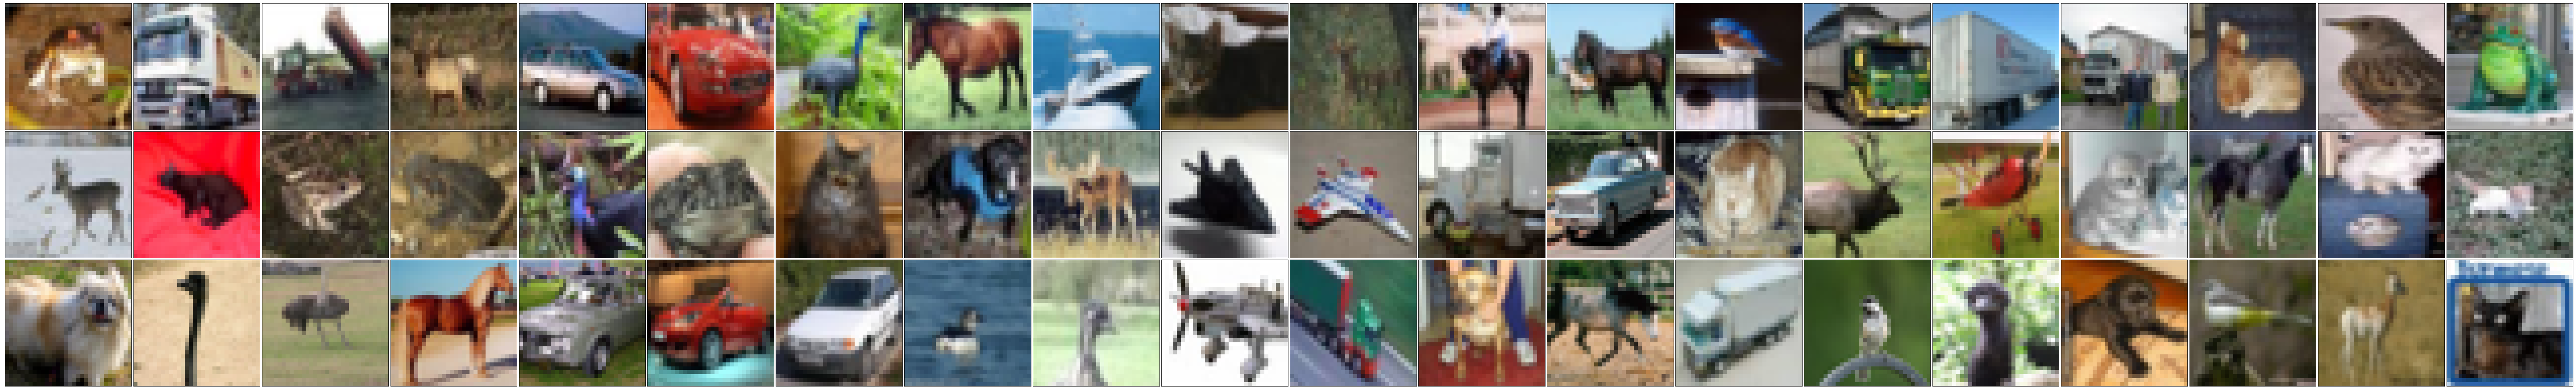

In [51]:
# show images
fig, axes = plt.subplots(nrows=3, ncols=20, sharex=True, sharey=True, figsize=(80,12))
imgs = x_train[:60]

for image, row in zip([imgs[:20], imgs[20:40], imgs[40:60]], axes):
    for img, ax in zip(image, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)


##### 4. CLEAN DATA

In [52]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

# reshape

x_train_rows = x_train.reshape(x_train.shape[0], 32 * 32 * 3)
x_test_rows = x_test.reshape(x_test.shape[0], 32 * 32 * 3)

In [53]:
# normalnization

x_train = minmax.fit_transform(x_train_rows)
x_test = minmax.fit_transform(x_test_rows)

In [54]:
# reshape pictures in 32 x 32 x 3

x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

### PART 2: TARGET VARIABLE (Y) ANALYSIS

In [55]:
# Target variable to encoding using one-hot
from sklearn.preprocessing import LabelBinarizer

n_class = 10 # 10 classes/labels
lb = LabelBinarizer().fit(np.array(range(n_class)))

In [56]:
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

### Part 3 Validation Framework

##### 1. Split data into 3 parts

In [57]:
from sklearn.model_selection import train_test_split

train_ratio = 0.8
x_train_, x_val, y_train_, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    train_size=train_ratio,
                                                    random_state=123)

### CNN

In [58]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tf_slim as tf_layers

In [59]:
img_shape = x_train.shape
keep_prob = 0.6
epochs=5
batch_size=64

In [60]:
# input and targets

inputs_ = tf.placeholder(tf.float32, [None, 32, 32, 3], name='inputs_')
targets_ = tf.placeholder(tf.float32, [None, n_class], name='targets_')

In [61]:
# Build Convolutional Networks

# The first layer of convolution and pooling
# 32 x 32 x 3 to 32 x 32 x 64
conv1 = tf.layers.conv2d(inputs_, 64, (2,2), padding='same', activation=tf.nn.relu, 
                         kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
# 32 x 32 x 64 to 16 x 16 x 64
conv1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')


# The second layer of convolution and pooling
# 16 x 16 x 64 to 16 x 16 x 128
conv2 = tf.layers.conv2d(conv1, 128, (4,4), padding='same', activation=tf.nn.relu,
                         kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
# 16 x 16 x 128 to 8 x 8 x 128
conv2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')

In [62]:
# reshape
shape = np.prod(conv2.get_shape().as_list()[1:])
conv2 = tf.reshape(conv2,[-1, shape])


In [63]:
# the first layer of fully connection 
# 8 x 8 x 128 to 1 x 1024
fc1 = tf_layers.fully_connected(conv2, 1024, activation_fn=tf.nn.relu)
fc1 = tf.nn.dropout(fc1, keep_prob)

# the second layer of fully connection 
# 1 x 1024 to 1 x 512
fc2 = tf_layers.fully_connected(fc1, 512, activation_fn=tf.nn.relu)

In [64]:
# logits layer
# 1 x 512 to 1 x 10
logits_ = tf_layers.fully_connected(fc2, 10, activation_fn=None)
logits_ = tf.identity(logits_, name='logits_')

# cost & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_, labels=targets_))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

# accuracy
correct_pred = tf.equal(tf.argmax(logits_, 1), tf.argmax(targets_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [65]:
# training 

count = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        for batch_i in range(img_shape[0]//batch_size-1):
            feature_batch = x_train_[batch_i * batch_size: (batch_i+1)*batch_size]
            label_batch = y_train_[batch_i * batch_size: (batch_i+1)*batch_size]
            train_loss, _ = sess.run([cost, optimizer],
                                     feed_dict={inputs_: feature_batch,
                                                targets_: label_batch})

            val_acc = sess.run(accuracy,
                               feed_dict={inputs_: x_val,
                                          targets_: y_val})
            
            if(count%10==0):
                print('Epoch {:>2}, Train Loss {:.4f}, Validation Accuracy {:4f} '.format(epoch + 1, train_loss, val_acc))
            
            count += 1     

Epoch  1, Train Loss 2.3669, Validation Accuracy 0.095000 
Epoch  1, Train Loss 2.3556, Validation Accuracy 0.111300 
Epoch  1, Train Loss 2.2987, Validation Accuracy 0.101500 
Epoch  1, Train Loss 2.2516, Validation Accuracy 0.139600 
Epoch  1, Train Loss 2.2449, Validation Accuracy 0.173200 
Epoch  1, Train Loss 1.9201, Validation Accuracy 0.205600 
Epoch  1, Train Loss 1.9464, Validation Accuracy 0.263700 
Epoch  1, Train Loss 1.9052, Validation Accuracy 0.268700 
Epoch  1, Train Loss 1.8131, Validation Accuracy 0.287100 
Epoch  1, Train Loss 1.6345, Validation Accuracy 0.327300 
Epoch  1, Train Loss 1.6028, Validation Accuracy 0.354700 
Epoch  1, Train Loss 1.7006, Validation Accuracy 0.363500 
Epoch  1, Train Loss 1.5779, Validation Accuracy 0.355900 
Epoch  1, Train Loss 1.6289, Validation Accuracy 0.384900 
Epoch  1, Train Loss 1.5805, Validation Accuracy 0.374800 
Epoch  1, Train Loss 1.6707, Validation Accuracy 0.389500 
Epoch  1, Train Loss 1.9301, Validation Accuracy 0.33790

Epoch  2, Train Loss 1.0712, Validation Accuracy 0.626500 
Epoch  2, Train Loss nan, Validation Accuracy 0.569700 
Epoch  2, Train Loss nan, Validation Accuracy 0.513800 
Epoch  2, Train Loss nan, Validation Accuracy 0.491800 
Epoch  2, Train Loss nan, Validation Accuracy 0.481000 
Epoch  2, Train Loss nan, Validation Accuracy 0.472200 
Epoch  2, Train Loss nan, Validation Accuracy 0.473600 
Epoch  2, Train Loss nan, Validation Accuracy 0.477500 
Epoch  2, Train Loss nan, Validation Accuracy 0.479100 
Epoch  2, Train Loss nan, Validation Accuracy 0.473400 
Epoch  2, Train Loss nan, Validation Accuracy 0.473200 
Epoch  2, Train Loss nan, Validation Accuracy 0.474000 
Epoch  2, Train Loss nan, Validation Accuracy 0.473000 
Epoch  2, Train Loss nan, Validation Accuracy 0.476800 
Epoch  2, Train Loss nan, Validation Accuracy 0.473100 
Epoch  2, Train Loss nan, Validation Accuracy 0.472700 
Epoch  3, Train Loss 1.3462, Validation Accuracy 0.543300 
Epoch  3, Train Loss 1.0027, Validation Ac

Epoch  4, Train Loss 0.7194, Validation Accuracy 0.648500 
Epoch  4, Train Loss 0.8941, Validation Accuracy 0.660300 
Epoch  4, Train Loss 0.4791, Validation Accuracy 0.658900 
Epoch  4, Train Loss 0.8838, Validation Accuracy 0.653300 
Epoch  4, Train Loss 0.7874, Validation Accuracy 0.652200 
Epoch  4, Train Loss 0.6663, Validation Accuracy 0.667500 
Epoch  4, Train Loss 0.5971, Validation Accuracy 0.663000 
Epoch  4, Train Loss 0.8545, Validation Accuracy 0.662100 
Epoch  4, Train Loss 0.6516, Validation Accuracy 0.659100 
Epoch  4, Train Loss 0.8012, Validation Accuracy 0.648800 
Epoch  4, Train Loss 0.7968, Validation Accuracy 0.653300 
Epoch  4, Train Loss 0.7497, Validation Accuracy 0.650700 
Epoch  4, Train Loss 0.8646, Validation Accuracy 0.660400 
Epoch  4, Train Loss 0.6721, Validation Accuracy 0.665900 
Epoch  4, Train Loss 0.5048, Validation Accuracy 0.656200 
Epoch  4, Train Loss 0.8641, Validation Accuracy 0.665400 
Epoch  4, Train Loss nan, Validation Accuracy 0.619200 


KeyboardInterrupt: 